Dataset loaded successfully.
Dataset head:
   sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entri

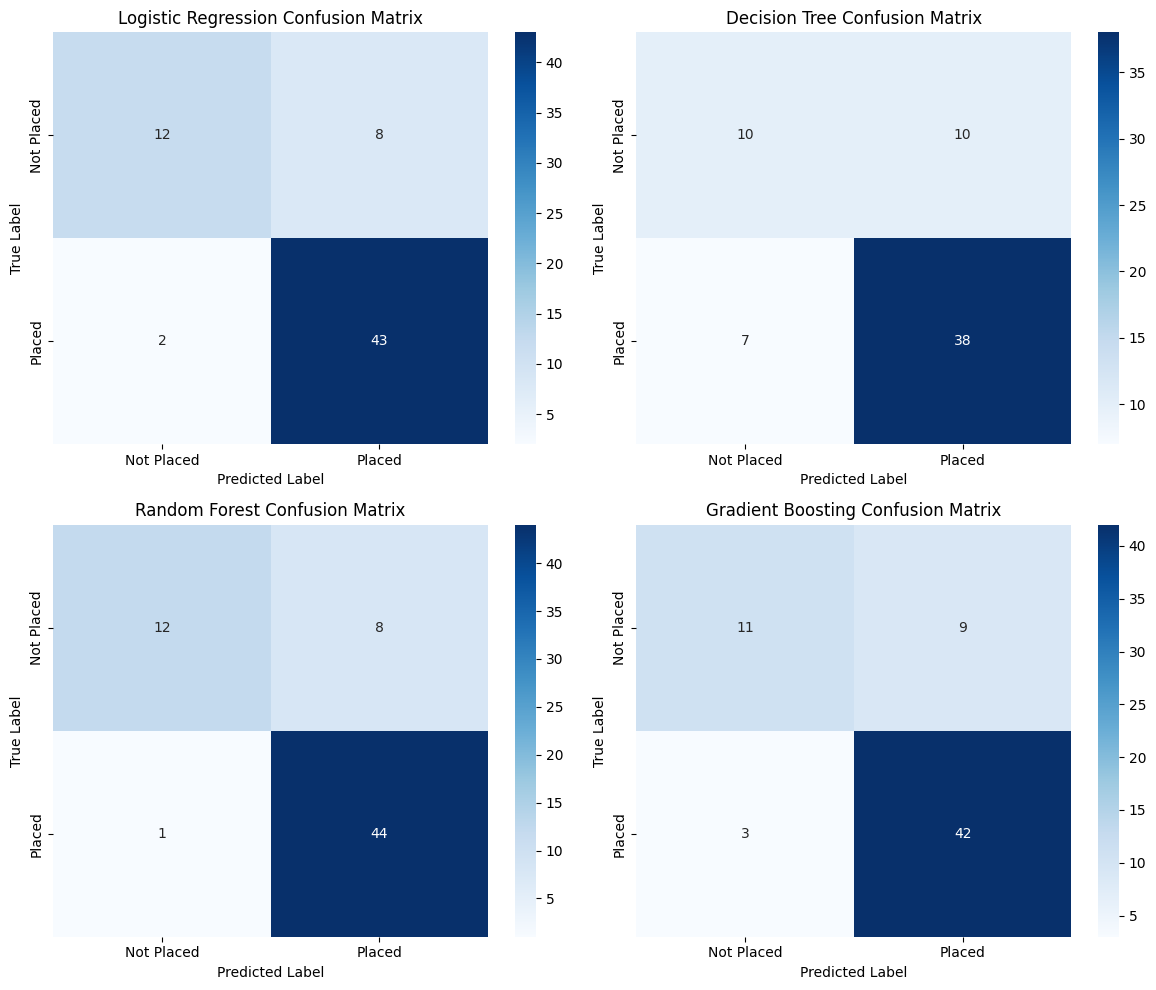

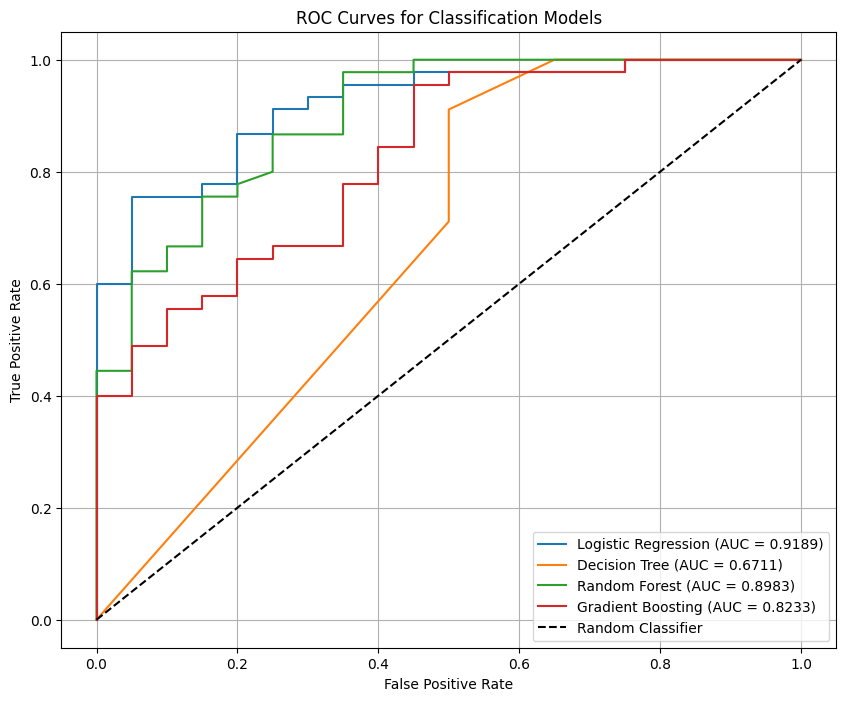


--- Voting Classifier ---
Training Voting Classifier...

--- Voting Classifier Results ---
Accuracy: 0.8615
Precision: 0.8333
Recall: 1.0000
F1-Score: 0.9091
ROC-AUC: 0.8656
Confusion Matrix:
 [[11  9]
 [ 0 45]]


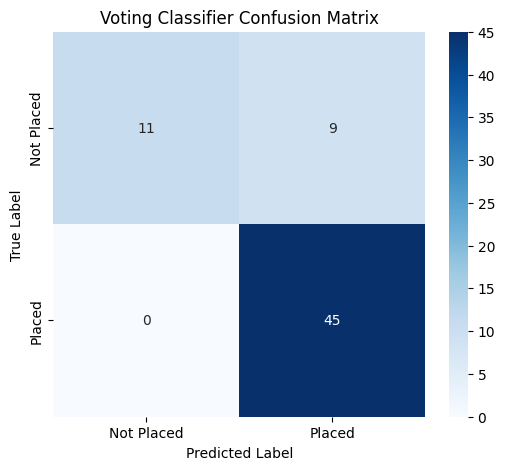


--- Comprehensive Performance Report ---
Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC
----------------------------------------------------------------------
Model                | Accuracy   | Precision  | Recall     | F1-Score   | ROC-AUC   
----------------------------------------------------------------------
Logistic Regression  | 0.8462     | 0.8431     | 0.9556     | 0.8958     | 0.9189    
Decision Tree        | 0.7385     | 0.7917     | 0.8444     | 0.8172     | 0.6711    
Random Forest        | 0.8615     | 0.8462     | 0.9778     | 0.9072     | 0.8983    
Gradient Boosting    | 0.8154     | 0.8235     | 0.9333     | 0.8750     | 0.8233    
Voting Classifier    | 0.8615     | 0.8333     | 1.0000     | 0.9091     | 0.8656    
----------------------------------------------------------------------

Conclusion:
The target variable for this analysis is 'status', predicting whether a student is 'Placed' or 'Not Placed'.
After preprocessing, which included dropping 'sl_no

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# --- 1. Dataset Selection & Loading ---
# Load the dataset
try:
    df = pd.read_csv('train.csv')
    print("Dataset loaded successfully.")
    print("Dataset head:")
    print(df.head())
    print("\nDataset info:")
    df.info()
except FileNotFoundError:
    print("Error: train.csv not found. Please ensure the file is in the correct directory.")
    exit()

# --- 2. Data Preprocessing ---

print("\n--- Data Preprocessing ---")

# Drop 'sl_no' as it's just an identifier and 'salary' as it's directly dependent on 'status' (target leakage for classification)
# If salary were to be predicted, it would be a regression problem. For 'status' classification, it's a leakage.
df = df.drop(['sl_no', 'salary'], axis=1)

# Exploratory Data Analysis (EDA) - Missing Values
print("\nMissing values before handling:")
print(df.isnull().sum())

# There are no missing values in the features relevant for status prediction.
# If there were, strategies like median imputation for numerical or mode imputation for categorical would be applied.

# EDA - Target variable distribution
print("\nTarget variable 'status' distribution:")
print(df['status'].value_counts())
print(df['status'].value_counts(normalize=True))

# Separate target variable from features
X = df.drop('status', axis=1)
y = df['status']

# Encode the target variable 'status'
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nEncoded 'status' categories: {le.classes_} mapped to {np.unique(y_encoded)}")

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features: {list(categorical_features)}")
print(f"Numerical features: {list(numerical_features)}")

# Preprocessing Pipelines
# For binary categorical features (gender, workex) use LabelEncoder within a custom transformer or map
# For multi-class categorical features (ssc_b, hsc_b, hsc_s, degree_t, specialisation) use OneHotEncoder
# For numerical features, use StandardScaler

# Manual mapping for binary categorical features if desired for clarity, otherwise OHE can handle it.
# Here, we'll let OneHotEncoder handle all categorical features, which will also convert binary ones.
# It's generally safer and more consistent.

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# --- 3. Model Selection, Training, and Hyperparameter Tuning ---

print("\n--- Model Training and Hyperparameter Tuning ---")

# Define models and their parameter grids for GridSearchCV
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, solver='liblinear'),
        'params': {
            'model__C': [0.01, 0.1, 1, 10, 100]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': [None, 5, 10, 15, 20],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [1, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5]
        }
    }
}

best_models = {}
results = {}

for name, config in models.items():
    print(f"\nTraining and tuning {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', config['model'])])

    grid_search = GridSearchCV(pipeline, config['params'], cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_
    y_pred = best_models[name].predict(X_test)
    y_prob = best_models[name].predict_proba(X_test)[:, 1] # Probability of the positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm,
        'Best Params': grid_search.best_params_
    }
    print(f"--- {name} Results ---")
    print(f"Best parameters: {results[name]['Best Params']}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", cm)

# --- 4. Evaluating the Models (Visualizations) ---

print("\n--- Model Evaluation Visualizations ---")

# Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    if name != 'Voting Classifier': # Exclude Voting Classifier here as it's plotted separately
        sns.heatmap(res['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=le.classes_, yticklabels=le.classes_)
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for name, model_pipeline in best_models.items():
    if hasattr(model_pipeline, "predict_proba"): # Check if model supports predict_proba for ROC
        y_prob = model_pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC-AUC"]:.4f})')
    else:
        print(f"Warning: {name} does not support predict_proba for ROC curve plotting.")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Voting Classifier ---

print("\n--- Voting Classifier ---")

# Prepare estimators for VotingClassifier (using the best trained individual models)
estimators = []
for name, model_pipeline in best_models.items():
    # VotingClassifier expects (name, model) tuples.
    # We need to extract the actual sklearn model from the pipeline for VotingClassifier to work properly
    # or ensure the pipeline itself is passed if it's designed to work within VotingClassifier.
    # Here, it's simpler to use the 'model' step of the best_estimator_ pipeline.
    # A cleaner way to integrate preprocessing into VotingClassifier is to ensure
    # each base estimator in VotingClassifier also includes the preprocessor, but that's redundant.
    # For simplicity, we assume VotingClassifier will receive preprocessed data if individual models
    # are trained on preprocessed data.
    # The 'best_models' are already pipelines that include the preprocessor.
    estimators.append((name.replace(" ", "_").lower(), model_pipeline)) # Names for estimators

# Create the VotingClassifier (using soft voting for probabilities)
# Make sure all estimators have predict_proba
voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

# Train the Voting Classifier
print("Training Voting Classifier...")
voting_clf.fit(X_train, y_train)

# Evaluate the Voting Classifier
y_pred_voting = voting_clf.predict(X_test)
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]

accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)
roc_auc_voting = roc_auc_score(y_test, y_prob_voting)
cm_voting = confusion_matrix(y_test, y_pred_voting)

results['Voting Classifier'] = {
    'Accuracy': accuracy_voting,
    'Precision': precision_voting,
    'Recall': recall_voting,
    'F1-Score': f1_voting,
    'ROC-AUC': roc_auc_voting,
    'Confusion Matrix': cm_voting,
    'Best Params': 'N/A (Ensemble)'
}

print("\n--- Voting Classifier Results ---")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1-Score: {f1_voting:.4f}")
print(f"ROC-AUC: {roc_auc_voting:.4f}")
print("Confusion Matrix:\n", cm_voting)

# Plot Confusion Matrix for Voting Classifier
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 6. Report Summary (Printed Output) ---

print("\n--- Comprehensive Performance Report ---")
print("Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC")
print("-" * 70)

# Display results in a table format
print(f"{'Model':<20} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'ROC-AUC':<10}")
print("-" * 70)
for name, res in results.items():
    # Corrected the format specifiers for floats: width should come before precision
    print(f"{name:<20} | {res['Accuracy']:<10.4f} | {res['Precision']:<10.4f} | {res['Recall']:<10.4f} | {res['F1-Score']:<10.4f} | {res['ROC-AUC']:<10.4f}")
print("-" * 70)

# Conclusion
# Determine the best performing model based on F1-Score (often a good balanced metric)
best_f1_score = 0
best_model_name = ""

for name, res in results.items():
    if name != 'Voting Classifier' and res['F1-Score'] > best_f1_score: # Exclude Voting Classifier from individual best model
        best_f1_score = res['F1-Score']
        best_model_name = name

# Compare Voting Classifier with the best individual model
if 'Voting Classifier' in results and results['Voting Classifier']['F1-Score'] > best_f1_score:
    best_model_name = 'Voting Classifier'
    best_f1_score = results['Voting Classifier']['F1-Score']


print(f"\nConclusion:")
print(f"The target variable for this analysis is 'status', predicting whether a student is 'Placed' or 'Not Placed'.")
print(f"After preprocessing, which included dropping 'sl_no' and 'salary' (due to target leakage), and encoding categorical features,")
print(f"four classification models (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting) were trained and tuned using GridSearchCV.")
print(f"A Voting Classifier (soft voting) was then implemented to combine the strengths of these models.")
print(f"\nBased on the F1-Score (a balanced metric for precision and recall), the **{best_model_name}** performed the best with an F1-Score of {best_f1_score:.4f}.")
print(f"The Voting Classifier often provides a more robust and generalized prediction by leveraging the diverse strengths of individual models.")
print(f"\nFurther analysis could involve feature engineering, exploring more complex models, or handling class imbalance if it were severe.")
